<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# Pre-Trained Models

Though it is often necessary to have a large, well annotated dataset to solve a deep learning challenge, there are many  freely available pre-trained models that we can use right out of the box. As you decide to take on your own deep learning project, it is a great idea to start by looking for existing models online that can help you achieve your goal. A great place to explore available models is [NGC](https://ngc.nvidia.com/catalog/models). There are also many models hosted on GitHub that you can find through searching on Google. 

## Objectives

* Use Keras to load a very well-trained pretrained model
* Preprocess your own images to work with the pretrained model
* Use the pretrained model to perform accurate inference on your own images

## An Automated Doggy Door

In this section, we will be creating a doggy door that only lets dogs (and not other animals) in and out. We can keep our cats inside, and other animals outside where they belong. Using the techniques covered so far, we would need a very large dataset with pictures of many dogs, as well as other animals. Luckily, there is a readily available model that has been trained on a massive dataset, including lots of animals. 

The [ImageNet challenge](https://en.wikipedia.org/wiki/ImageNet#History_of_the_ImageNet_challenge) has produced many state-of-the-art models that can be used for image classification. They are trained on millions of images, and can accurately classify images into 1000 different categories. Many of those categories are animals, including breeds of dogs and cats. This is a perfect model for our doggy door.

## Loading the Model

We will start by downloading the model. Trained ImageNet models are available to download directly within the Keras library. You can see the available models and their details [here](https://keras.io/api/applications/#available-models). Any of these models would work for our exercise. We will pick a commonly used one called [VGG16](https://keras.io/api/applications/vgg/):

In [2]:
from tensorflow.keras.applications import VGG16
  
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")

Now that it is loaded, let us take a look at the model. It looks a lot like our convolutional model from the sign language exercise. Pay attention to the first layer (the input layer) and the last layer (the output layer). As with our earlier exercises, we need to make sure our images match the input dimensions that the model expects. It is also valuable to understand what the model will return from the final output layer.

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Input dimensions
We can see that the model is expecting images in the shape of (224, 224, 3) corresponding to 224 pixels high, 224 pixels wide, and 3 color channels. As we learned in our last exercise, Keras models can accept more than one image at a time for prediction. If we pass in just one image, the shape will be (1, 224, 224, 3). We will need to make sure that when passing images into our model for prediction, they match these dimensions. 

### Output dimensions
We can also see that the model will return a prediction of shape 1000. Remember that in our first exercise the output shape of our model was 10, corresponding to the 10 different digits. In our second exercise we had a shape of 24, corresponding to the 24 letters of the sign language alphabet that could be captured in a still image. Here, we have 1000 possible categories that the image will be placed in. Though the full ImageNet dataset has over 20,000 categories, the competition and resulting pre-trained models just use a subset of 1000 of these categories. We can take a look at all of these [possible categories here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

Many of the categories are animals, including many types of dogs and cats. The dogs are categories 151 through 268. The cats are categories 281 through 285. We will be able to use these categories to tell our doggy door what type of animal is at our door, and whether we should let them in or not.

## Loading an Image
We will start by loading in an image and displaying it, as we have done in previous exercises.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(1200, 1800, 3)


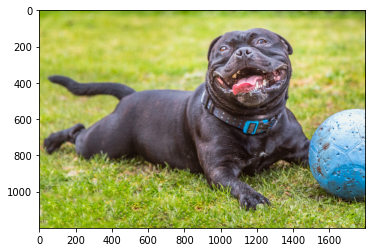

In [5]:
show_image("data/doggy_door_images/happy_dog.jpg")

## Preprocessing the Image

Next, we need to preprocess the image so that it is ready to be sent into the model. This is just like what we did in our last exercise when we predicted on the sign language images. Remember that in this case, the final shape of the image needs to be (1, 224, 224, 3).

When loading models directly with Keras, we can also take advantage of [`preprocess_input` methods](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input). These methods, associated with a specific model, allow users to preprocess their own images to match the qualities of the images that the model was originally trained on. We had to do this manually yourself when performing inference with new ASL images:

In [6]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

In [7]:
processed_image = load_and_process_image("data/doggy_door_images/brown_bear.jpg")

Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)


## Make a Prediction

Now that we have our image in the right format, we can pass it into our model and get a prediction. We are expecting an output of an array of 1000 elements, which is going to be difficult to read. Fortunately, models loaded directly with Keras have yet another helpful method that will translate that prediction array into a more readable form. 

Fill in the following function to implement the prediction:

In [8]:
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

### Solution

Click on the '...' below to see the solution.

In [13]:
# SOLUTION
from tensorflow.keras.applications.vgg16 import decode_predictions
import numpy as np

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form    
    print('Max:', np.argmax(predictions))
    print('Predicted:', decode_predictions(predictions, top=3))

Try it out on a few animals to see the results! Also feel free to upload your own images and categorize them just to see how well it works.

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
40960/35363 [==================================] - 0s 0us/step
Predicted: [[('n02093256', 'Staffordshire_bullterrier', 0.4509805), ('n02110958', 'pug', 0.32263243), ('n02099712', 'Labrador_retriever', 0.09343209)]]


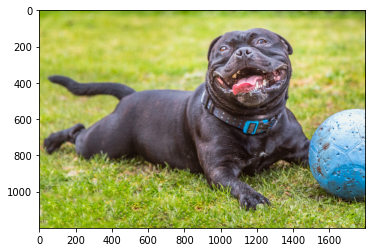

In [9]:
readable_prediction("data/doggy_door_images/happy_dog.jpg")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02132136', 'brown_bear', 0.9853864), ('n02133161', 'American_black_bear', 0.013876191), ('n02410509', 'bison', 0.00026603678)]]


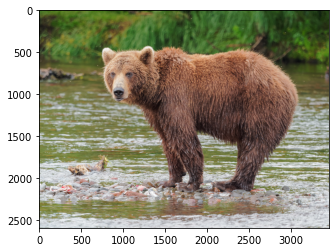

In [10]:
readable_prediction("data/doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02123159', 'tiger_cat', 0.73654705), ('n02124075', 'Egyptian_cat', 0.17492658), ('n02123045', 'tabby', 0.045884028)]]


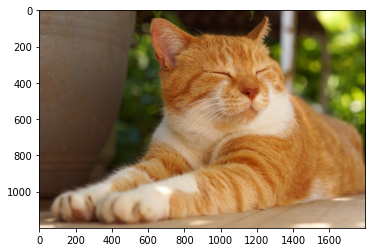

In [11]:
readable_prediction("data/doggy_door_images/sleepy_cat.jpg")

(509, 508, 3)
Original image shape:  (509, 508, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02125311', 'cougar', 0.33749133), ('n02128385', 'leopard', 0.14215672), ('n02127052', 'lynx', 0.12713593)]]


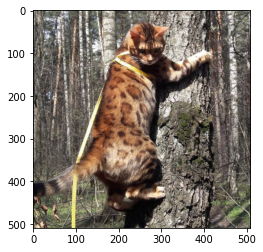

In [14]:
readable_prediction("data/MYphoto/Amur.jpg")

(269, 270, 3)
Original image shape:  (269, 270, 3)
Processed image shape:  (1, 224, 224, 3)
Max: 286
Predicted: [[('n02125311', 'cougar', 0.29672053), ('n02129604', 'tiger', 0.16977896), ('n02123159', 'tiger_cat', 0.1486107)]]


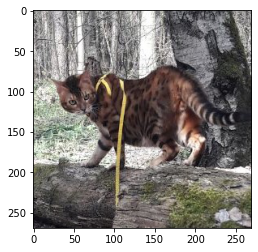

In [14]:
readable_prediction("data/MYphoto/Amur2.jpg")

## Only Dogs

Now that we are making predictions with our model, we can use our categories to only let dogs in and out and keep cats inside. Remember that dogs are categories 151 through 268 and cats are categories 281 through 285. The [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function can find which element of the prediction array is the top category.

In [16]:
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

### Solution

Click on the '...' below to see the solution.

In [ ]:
# SOLUTION
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
You're not a dog! Stay outside!


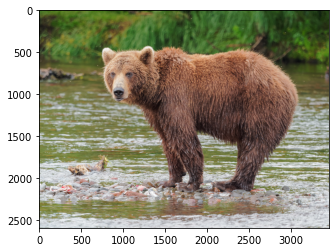

In [17]:
doggy_door("data/doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Doggy come on in!


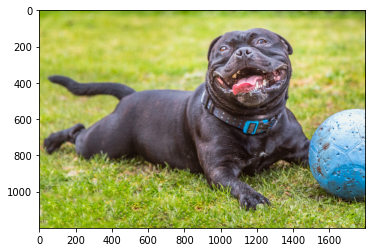

In [18]:
doggy_door("data/doggy_door_images/happy_dog.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Kitty stay inside!


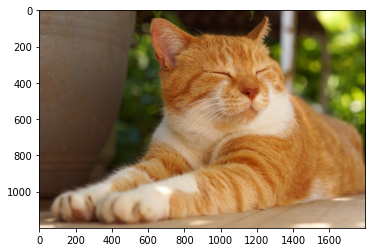

In [19]:
doggy_door("data/doggy_door_images/sleepy_cat.jpg")

## Summary

Great work! Using a powerful pre-trained model, we have created a functional doggy door in just a few lines of code. We hope you are excited to realize that you can take advantage of deep learning without a lot of up-front work. The best part is, as the deep learning community moves forward, more models will become available for you to use on your own projects.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [15]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Next

Using pretrained models is incredibly powerful, but sometimes they are not a perfect fit for your data. In the next section you will learn about another powerful technique, *transfer learning*, which allows you to tailer pretrained models to make good predictions for your data.

Continue to the next section: [*Pretrained Models*](./05b_presidential_doggy_door.ipynb).

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>